1. DATA LOAD

In [ ]:
# 1. 기존 폴더 완전히 삭제
!rm -rf /content/bdd100k_night
!rm -rf /content/bdd_night_test
!rm -rf /content/bdd_night_final

print("✅ 모든 데이터가 초기화되었습니다. 다시 압축을 풀어주세요.")

✅ 모든 데이터가 초기화되었습니다. 다시 압축을 풀어주세요.


In [ ]:
from google.colab import drive
import os

# 1. 구글 드라이브 마운트
drive.mount('/content/drive')

# 2. ZIP 파일 경로 설정 (본인의 실제 경로로 수정하세요)
zip_path = '/content/drive/MyDrive/bdd100k-finetune.v3-bdd100k-night-v3.coco.zip'
target_dir = '/content/bdd100k_night'

# 3. 압축 해제
if not os.path.exists(target_dir):
    os.makedirs(target_dir)
    !unzip -q "{zip_path}" -d "{target_dir}"
    print("압축 해제 완료!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
압축 해제 완료!


2. DATASET 시각화

[TRAIN] 이미지: 27445장, 박스 개수: 361859개


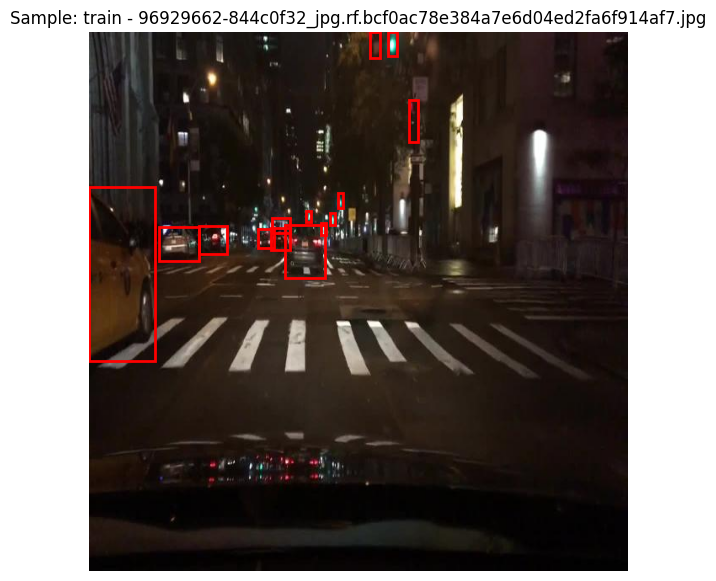

[VALID] 이미지: 4394장, 박스 개수: 58316개


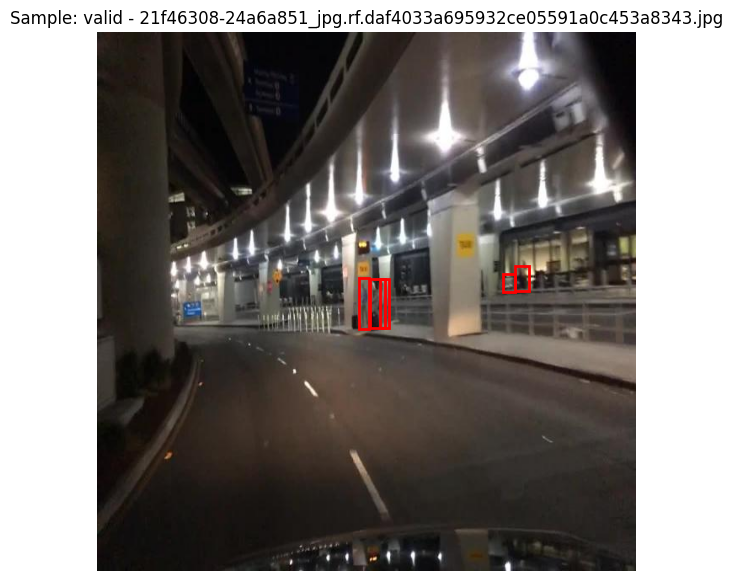

[TEST] 이미지: 60장, 박스 개수: 881개


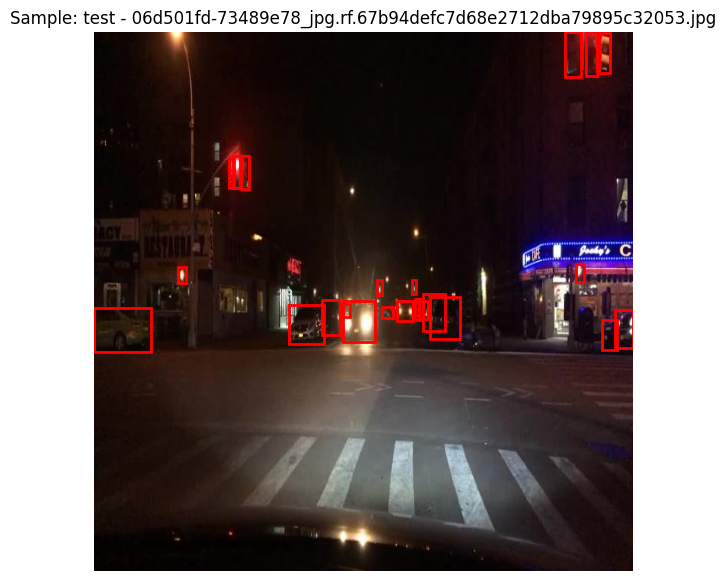

In [ ]:
import json
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import random

def check_and_visualize(base_path, split_name):
    # 1. 경로 설정 (폴더명이 valid인지 val인지 확인 필요)
    split_path = os.path.join(base_path, split_name)
    ann_path = os.path.join(split_path, "_annotations.coco.json")

    if not os.path.exists(ann_path):
        print(f"경로를 찾을 수 없습니다: {ann_path}")
        return

    # 2. JSON 데이터 로드
    with open(ann_path, 'r') as f:
        data = json.load(f)

    # 3. 이미지 개수 출력
    num_images = len(data['images'])
    num_anns = len(data['annotations'])
    print(f"[{split_name.upper()}] 이미지: {num_images}장, 박스 개수: {num_anns}개")

    # 4. 랜덤 샘플 시각화 (좌표 변환 없이 원본 그대로)
    sample_img_info = random.choice(data['images'])
    img_id = sample_img_info['id']
    img_name = sample_img_info['file_name']

    # 이미지 불러오기
    img_path = os.path.join(split_path, img_name)
    img = Image.open(img_path)

    plt.figure(figsize=(12, 7))
    plt.imshow(img)
    ax = plt.gca()

    # 해당 이미지의 박스(annotations)만 찾아서 그리기
    for ann in data['annotations']:
        if ann['image_id'] == img_id:
            # COCO 원본 좌표: [x_min, y_min, width, height]
            x, y, w, h = ann['bbox']

            # 박스 그리기 (변환 없이 원본 좌표 사용)
            rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='red', facecolor='none')
            ax.add_patch(rect)

    plt.title(f"Sample: {split_name} - {img_name}")
    plt.axis('off')
    plt.show()

# --- 실행 부분 ---
root_path = '/content/bdd100k_night'

# 폴더명이 다를 수 있으니 리스트를 확인하세요
for s in ['train', 'valid', 'test']:
    check_and_visualize(root_path, s)

3. COCO-> YOLO 변환

In [ ]:
!pip install -q ultralytics
import os
import json
import shutil
from tqdm import tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 23.6 MB/s eta 0:00:00


In [ ]:
def convert_coco_to_yolo(base_path, split_name):
    split_path = os.path.join(base_path, split_name)
    json_path = os.path.join(split_path, "_annotations.coco.json")

    # 1. 새 구조 생성 (images, labels)
    new_img_dir = os.path.join(split_path, 'images_new')
    new_lbl_dir = os.path.join(split_path, 'labels')
    os.makedirs(new_img_dir, exist_ok=True)
    os.makedirs(new_lbl_dir, exist_ok=True)

    with open(json_path, 'r') as f:
        data = json.load(f)

    # 카테고리 매핑 (ID가 0부터 시작하도록 조정)
    categories = {cat['id']: i for i, cat in enumerate(data['categories'])}

    # 이미지 정보 로드
    images = {img['id']: img for img in data['images']}

    # 2. 어노테이션 변환
    for ann in tqdm(data['annotations'], desc=f"Converting {split_name}"):
        img_info = images[ann['image_id']]
        img_w, img_h = img_info['width'], img_info['height']
        img_name = img_info['file_name']

        # YOLO 좌표 계산 (Normalized center_x, center_y, width, height)
        x, y, w, h = ann['bbox']
        cx = (x + w / 2) / img_w
        cy = (y + h / 2) / img_h
        nw = w / img_w
        nh = h / img_h

        cls_id = categories[ann['category_id']]

        # 텍스트 파일 저장
        txt_name = os.path.splitext(img_name)[0] + ".txt"
        with open(os.path.join(new_lbl_dir, txt_name), 'a') as f:
            f.write(f"{cls_id} {cx:.6f} {cy:.6f} {nw:.6f} {nh:.6f}\n")

    # 3. 이미지 이동 및 정리
    for img_id in images:
        img_name = images[img_id]['file_name']
        old_path = os.path.join(split_path, img_name)
        new_path = os.path.join(new_img_dir, img_name)
        if os.path.exists(old_path):
            shutil.move(old_path, new_path)

    # 기존 폴더 교체 (깔끔한 구조 유지)
    # 기존에 이미지가 있던 자리를 'images' 폴더로 변경
    os.rename(new_img_dir, os.path.join(split_path, 'images'))
    print(f"\n{split_name} 변환 완료!")

# 실행
root_path = '/content/bdd100k_night'
for s in ['train', 'valid', 'test']:
    convert_coco_to_yolo(root_path, s)

Converting train: 100%|██████████| 361859/361859 [00:09<00:00, 39614.43it/s]



train 변환 완료!


Converting valid: 100%|██████████| 58316/58316 [00:01<00:00, 40401.78it/s]



valid 변환 완료!


Converting test: 100%|██████████| 881/881 [00:00<00:00, 40142.33it/s]


test 변환 완료!


In [ ]:
import os

def check_dataset_counts(base_path):
    # 확인할 데이터셋 스플릿 리스트 (폴더 구조에 맞게 수정)
    splits = ['train', 'valid', 'test']

    print(f"{'Split':<10} | {'Images':<10} | {'Labels':<10} | {'Status'}")
    print("-" * 50)

    for split in splits:
        split_path = os.path.join(base_path, split)

        # 폴더 존재 확인
        if not os.path.exists(split_path):
            continue

        img_path = os.path.join(split_path, 'images')
        lbl_path = os.path.join(split_path, 'labels')

        # 이미지와 라벨 파일 리스트 추출 (확장자 필터링)
        images = [f for f in os.listdir(img_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))] if os.path.exists(img_path) else []
        labels = [f for f in os.listdir(lbl_path) if f.lower().endswith('.txt')] if os.path.exists(lbl_path) else []

        # 정합성 확인 (이미지 개수와 라벨 개수가 맞는지)
        status = "✅ OK" if len(images) == len(labels) and len(images) > 0 else "❌ Mismatch or Empty"

        print(f"{split:<10} | {len(images):<10} | {len(labels):<10} | {status}")

# 실행
root_path = '/content/bdd100k_night'
check_dataset_counts(root_path)

Split      | Images     | Labels     | Status
--------------------------------------------------
train      | 27445      | 27326      | ❌ Mismatch or Empty
valid      | 4394       | 4373       | ❌ Mismatch or Empty
test       | 60         | 60         | ✅ OK


In [ ]:
import os

# 경로 설정
base_path = '/content/bdd100k_night'
label_dirs = ['train/labels', 'valid/labels', 'test/labels']

# 매핑 규칙 (전달해주신 딕셔너리 기준)
# Vehicle (0): bike(11), bus(12), car(13), motor(14), train(21), truck(22)
# Pedestrian (1): person(15), rider(16)
vehicle_ids = [11, 12, 13, 14, 21, 22]
pedestrian_ids = [15, 16]

print("🚀 클래스 ID 변환 시작 (13 -> 0 등)...")

for dtype in label_dirs:
    target_dir = os.path.join(base_path, dtype)
    if not os.path.exists(target_dir): continue

    for label_file in os.listdir(target_dir):
        if not label_file.endswith('.txt'): continue

        file_path = os.path.join(target_dir, label_file)
        new_lines = []

        with open(file_path, 'r') as f:
            for line in f:
                parts = line.split()
                if not parts: continue

                old_id = int(parts[0])
                if old_id in vehicle_ids:
                    new_id = 0  # Vehicle
                elif old_id in pedestrian_ids:
                    new_id = 1  # Pedestrian
                else:
                    continue # 17(신호등) 등 나머지는 무시

                new_lines.append(f"{new_id} {' '.join(parts[1:])}\n")

        # 수정된 내용 덮어쓰기
        with open(file_path, 'w') as f:
            f.writelines(new_lines)

print("✅ 모든 라벨의 숫자가 0 또는 1로 바뀌었습니다!")

🚀 클래스 ID 변환 시작 (13 -> 0 등)...
✅ 모든 라벨의 숫자가 0 또는 1로 바뀌었습니다!


In [ ]:
import os
import yaml

# 1. 경로 설정
dataset_path = '/content/bdd100k_night'
label_dirs = ['labels/train', 'labels/valid', 'labels/test']

# 2. 사용자님 요청 기반 매핑 (ID 기준)
# Vehicle (0): bike(11), bus(12), car(13), motor(14), truck(22)
# Pedestrian (1): person(15), rider(16)
# ※ 21번(train)은 제외됩니다.
vehicle_ids = [11, 12, 13, 14, 22]
pedestrian_ids = [15, 16]

print("🚀 사용자 정의 매핑 시작 (기차 제외, Vehicle/Pedestrian 통합)...")

for dtype in label_dirs:
    target_dir = os.path.join(dataset_path, dtype)
    if not os.path.exists(target_dir): continue

    for label_file in os.listdir(target_dir):
        if not label_file.endswith('.txt'): continue

        file_path = os.path.join(target_dir, label_file)
        new_lines = []

        with open(file_path, 'r') as f:
            for line in f:
                parts = line.split()
                if not parts: continue

                class_id = int(parts[0])

                # --- 매핑 로직 ---
                if class_id in vehicle_ids:
                    new_id = 0
                elif class_id in pedestrian_ids:
                    new_id = 1
                else:
                    # 기차(21), 신호등 등은 여기서 걸러집니다.
                    continue

                new_lines.append(f"{new_id} {' '.join(parts[1:])}\n")

        with open(file_path, 'w') as f:
            f.writelines(new_lines)

print("✅ 라벨 수정 완료! (기차 제외됨)")

# 3. data.yaml 생성
data_config = {
    'path': dataset_path,
    'train': 'train/images',
    'val': 'valid/images',
    'test': 'test/images',
    'nc': 2,
    'names': ['Vehicle', 'Pedestrian']
}

with open(os.path.join(dataset_path, 'data.yaml'), 'w') as f:
    yaml.dump(data_config, f, sort_keys=False)

print("✅ data.yaml 업데이트 완료!")

🚀 사용자 정의 매핑 시작 (기차 제외, Vehicle/Pedestrian 통합)...
✅ 라벨 수정 완료! (기차 제외됨)
✅ data.yaml 업데이트 완료!


5. MODEL 학습

In [ ]:
# 모든 하위 디렉토리를 탐색하여 .cache 파일을 찾아 삭제
!find /content/bdd100k_night -name "*.cache" -delete

# 삭제가 잘 되었는지 확인 (아무것도 출력되지 않으면 성공)
!find /content/bdd100k_night -name "*.cache"

In [ ]:
import yaml
from ultralytics import YOLO

# 1. data.yaml 업데이트
data_config = {
    'path': '/content/bdd100k_night',
    'train': 'train/images',
    'val': 'valid/images',
    'test': 'test/images',
    'nc': 2,
    'names': ['Vehicle', 'Pedestrian']
}

with open('/content/bdd100k_night/data.yaml', 'w') as f:
    yaml.dump(data_config, f, sort_keys=False)

# 2. YOLOv11s 학습 시작
model = YOLO("yolo11s.pt")

model.train(
    data='/content/bdd100k_night/data.yaml',
    epochs=20,
    imgsz=640,
    batch=32,            # 32에서 에러나면 16이 안전합니다
    device=0,
    optimizer='AdamW',
    project='/content/drive/MyDrive/YOLOv11_Night',
    name='bdd100k_final_fix',
    exist_ok=True,
    cache=False,
    workers=2,           # Thread 에러 방지를 위해 낮춤
    close_mosaic=10      # 학습 마지막 10에폭은 모자이크 증강을 꺼서 정확도 향상
)

Ultralytics 8.3.252 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/bdd100k_night/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=bdd100k_final_fix, nbs=64, nms=False, opset=None, optimize=False, optimizer=AdamW, overlap_mask=True, patience=100, perspecti

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7c6e142f1250>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04804

6. 학습 결과 확인

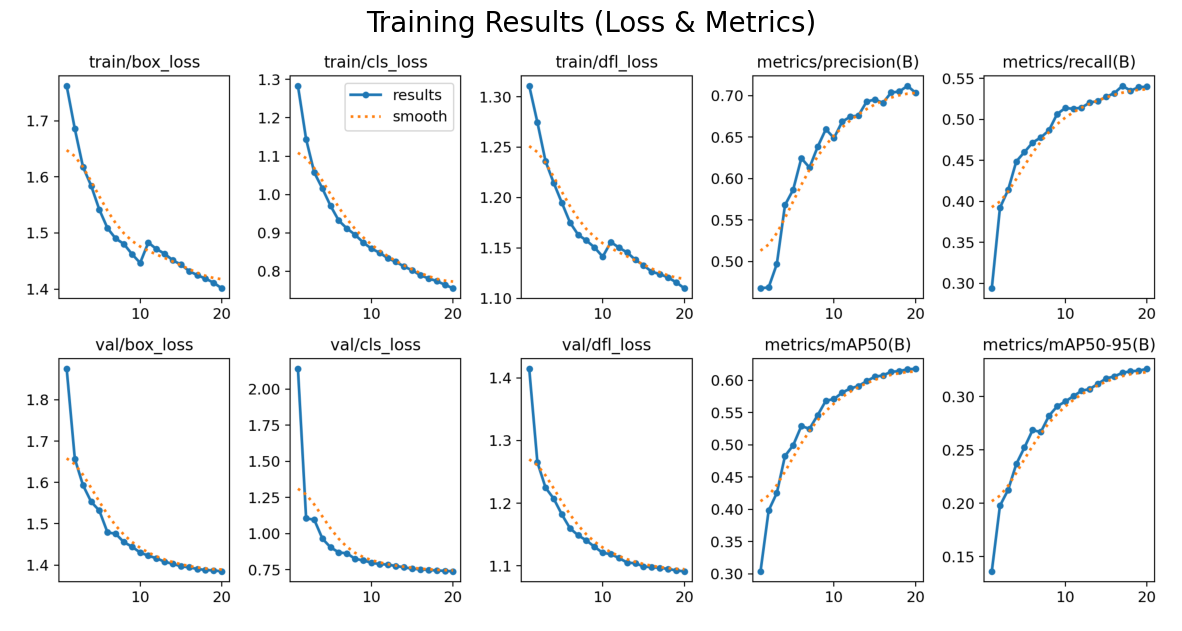

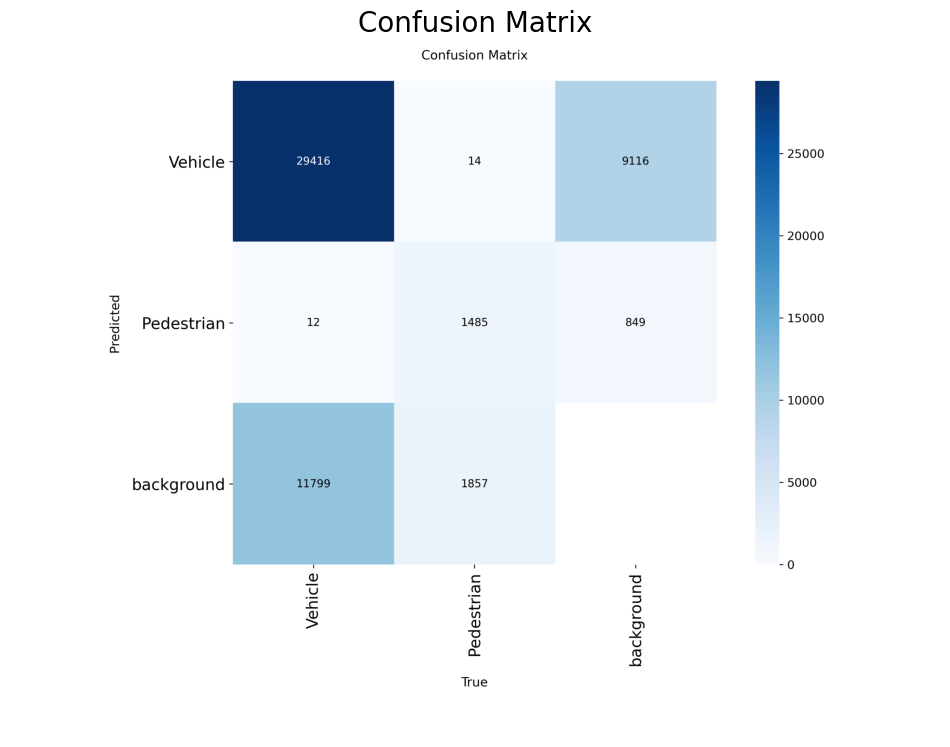


🔍 실제 예측 결과 비교 (상단: 정답 / 하단: 모델 예측)


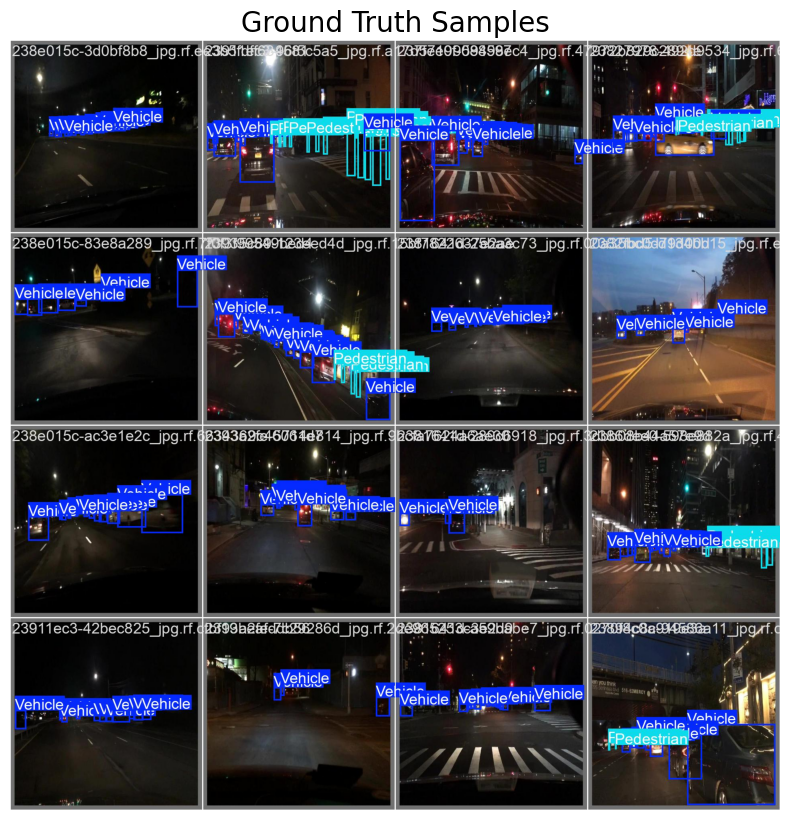

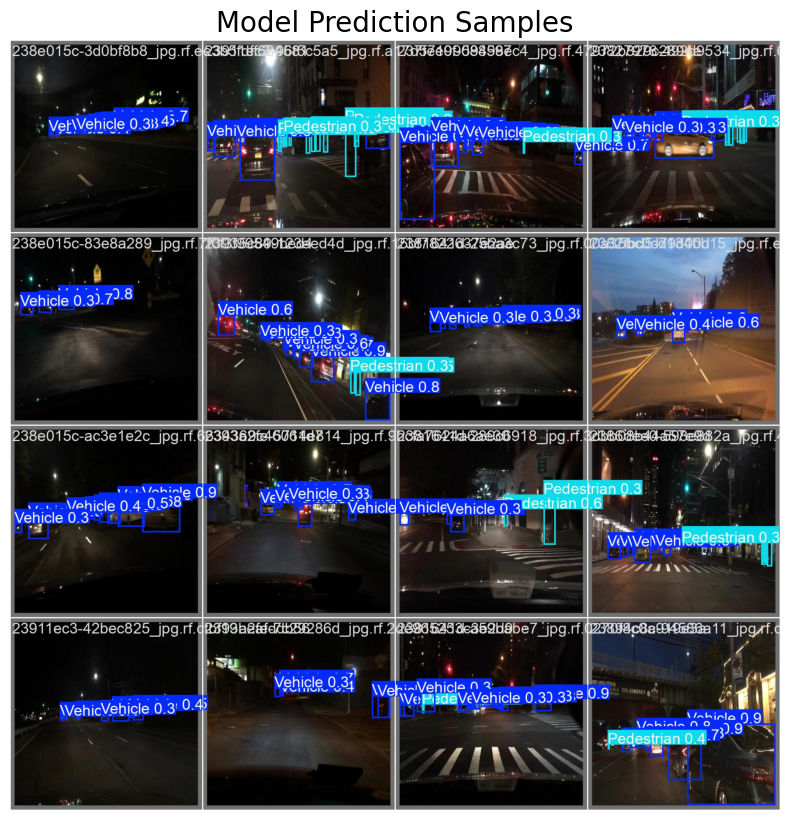

⚠️ F1_curve.png 파일을 찾을 수 없습니다. 아직 학습 중이거나 경로를 확인해주세요.


In [ ]:
import matplotlib.pyplot as plt
import cv2
import os
import glob

# 1. 경로 설정 (학습 코드의 project + name과 반드시 일치해야 합니다)
result_dir = '/content/drive/MyDrive/YOLOv11_Night/bdd100k_final_fix'

def show_result_image(file_name, title, figsize=(15, 10)):
    img_path = os.path.join(result_dir, file_name)
    if os.path.exists(img_path):
        img = cv2.imread(img_path)
        plt.figure(figsize=figsize)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(title, fontsize=20)
        plt.axis('off')
        plt.show()
    else:
        print(f"⚠️ {file_name} 파일을 찾을 수 없습니다. 아직 학습 중이거나 경로를 확인해주세요.")

# --- (1) 학습 곡선 확인 (Loss, mAP, Precision, Recall) ---
# 모델이 과적합(Overfitting)되지 않고 잘 내려가는지 확인하는 용도입니다.
show_result_image('results.png', 'Training Results (Loss & Metrics)')

# --- (2) Confusion Matrix (혼동 행렬) 확인 ---
# Vehicle과 Pedestrian을 서로 헷갈려하는지, 혹은 배경을 물체로 오인하는지 분석합니다.
show_result_image('confusion_matrix.png', 'Confusion Matrix', figsize=(12, 10))

# --- (3) 실제 검증 데이터 예측 샘플 확인 ---
# 모델이 실제로 밤거리에서 물체를 어떻게 잡았는지 눈으로 확인합니다.
# val_batch0_labels: 정답(Ground Truth) / val_batch0_pred: 모델의 예측값
print("\n🔍 실제 예측 결과 비교 (상단: 정답 / 하단: 모델 예측)")
show_result_image('val_batch0_labels.jpg', 'Ground Truth Samples')
show_result_image('val_batch0_pred.jpg', 'Model Prediction Samples')

# --- (4) PR 곡선 및 F1 스코어 확인 (선택 사항) ---
# 특정 클래스(예: 사람)의 성능이 유독 낮은지 확인할 수 있습니다.
show_result_image('F1_curve.png', 'F1-Confidence Curve', figsize=(10, 8))

best.pt로 test확인

In [ ]:
from ultralytics import YOLO
import os

# 1. 학습된 최적의 모델 불러오기
# (최신 실험 폴더인 'bdd100k_final_fix' 경로를 사용합니다)
best_model_path = '/content/drive/MyDrive/YOLOv11_Night/bdd100k_final_fix/weights/best.pt'

if os.path.exists(best_model_path):
    model = YOLO(best_model_path)
    print("✅ 최적의 가중치 모델을 성공적으로 불러왔습니다.")
else:
    print("❌ 모델 파일을 찾을 수 없습니다. 경로를 다시 확인해주세요.")

# 2. Test 데이터셋으로 최종 평가
# split='test'를 통해 data.yaml에 설정된 test 경로의 데이터를 사용합니다.
metrics = model.val(
    data='/content/bdd100k_night/data.yaml',
    split='test',
    imgsz=640,
    batch=16,
    device=0
)

# 3. 주요 지표 출력 (LaTeX 적용)
print("\n" + "🚀" + " [최종 테스트 결과 리포트] " + "="*20)
print(f"🔹 전체 $mAP_{{50-95}}$: {metrics.box.map:.4f} (정밀한 정확도)")
print(f"🔹 전체 $mAP_{{50}}$: {metrics.box.map50:.4f} (일반적인 정확도)")
print(f"🔹 정밀도(Precision): {metrics.box.mp:.4f}")
print(f"🔹 재현율(Recall): {metrics.box.mr:.4f}")
print("="*50)

# 4. 클래스별 상세 점수 출력
print("\n📊 [클래스별 $mAP_{{50-95}}$ 상세 점수]")
for i, name in model.names.items():
    cls_map = metrics.box.maps[i]
    print(f" - {name.upper():<10}: {cls_map:.4f}")

✅ 최적의 가중치 모델을 성공적으로 불러왔습니다.
Ultralytics 8.3.252 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
YOLO11s summary (fused): 100 layers, 9,413,574 parameters, 0 gradients, 21.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 702.1±317.0 MB/s, size: 27.9 KB)
val: Scanning /content/bdd100k_night/test/labels... 60 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 60/60 1.5Kit/s 0.0s
val: New cache created: /content/bdd100k_night/test/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 4/4 1.9it/s 2.1s
                   all         60        649      0.775      0.615      0.671      0.342
               Vehicle         60        635      0.756      0.658      0.744      0.417
            Pedestrian          9         14      0.794      0.571      0.598      0.266
Speed: 3.6ms preprocess, 10.3ms inference, 0.0ms loss, 7.3ms postprocess per image
Results saved to /content/runs/detect/val


Test 결과 시각화

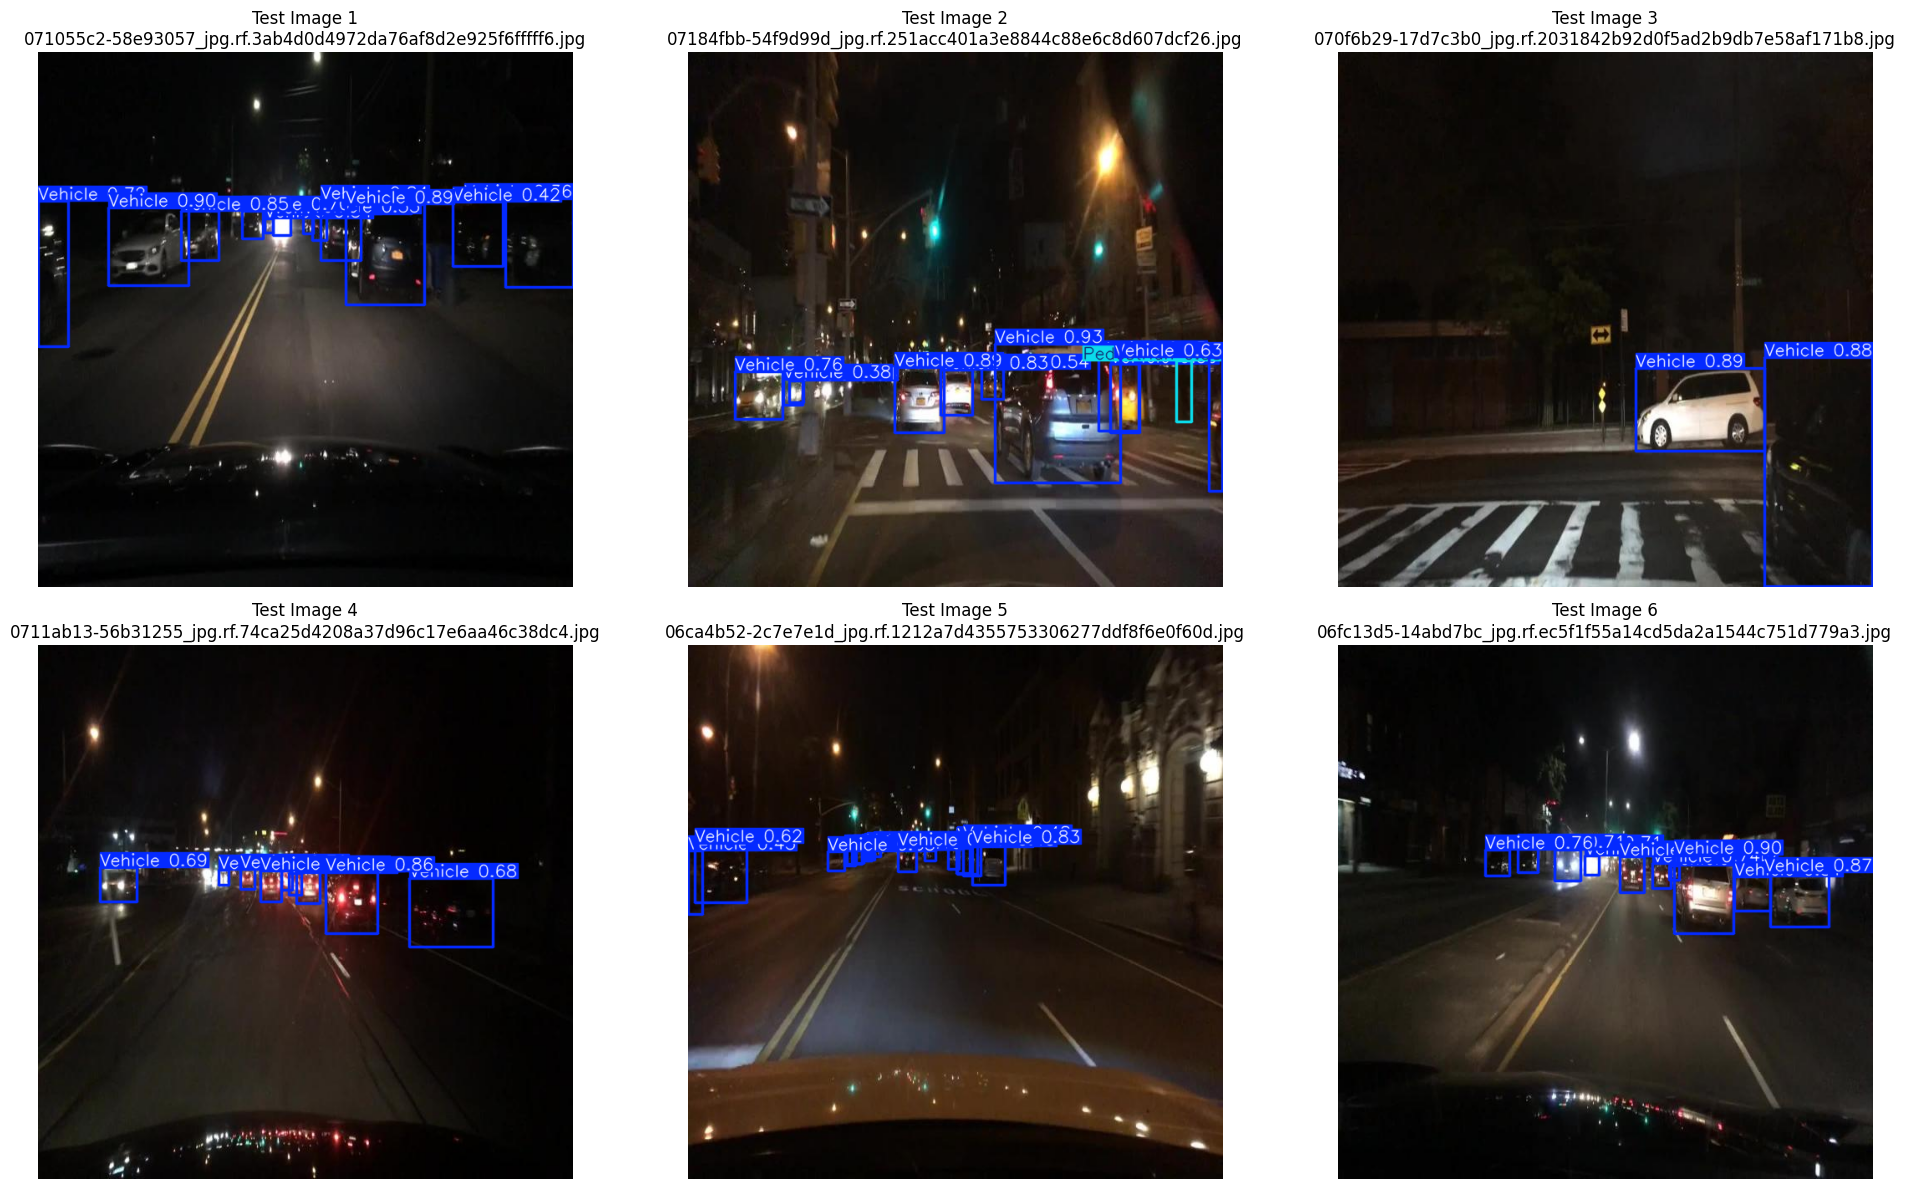

In [ ]:
import glob
import random
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO
import os

# 1. 최적의 모델 로드 (최종 실험 경로 반영)
best_model_path = '/content/drive/MyDrive/YOLOv11_Night/bdd100k_final_fix/weights/best.pt'

if not os.path.exists(best_model_path):
    print("❌ 모델 파일을 찾을 수 없습니다. 경로를 확인해주세요.")
else:
    model = YOLO(best_model_path)

    # 2. 테스트 이미지 경로 설정 및 샘플링
    test_img_list = glob.glob('/content/bdd100k_night/test/images/*.jpg')

    if len(test_img_list) < 6:
        print(f"⚠️ 테스트 이미지가 부족합니다. 현재 개수: {len(test_img_list)}")
        num_samples = len(test_img_list)
    else:
        num_samples = 6

    # 6장을 무작위로 샘플링
    sample_images = random.sample(test_img_list, num_samples)

    # 3. 시각화 설정
    plt.figure(figsize=(20, 12))

    for i, img_path in enumerate(sample_images):
        # 모델 추론 (conf: 임계값, imgsz: 입력 크기)
        results = model.predict(source=img_path, conf=0.3, imgsz=640, verbose=False)

        # 결과 시각화 (Bounding Box와 Label이 그려진 이미지 생성)
        # line_width: 박스 두께, font_size: 글자 크기 조절 가능
        res_plotted = results[0].plot(line_width=2, font_size=1)

        # Matplotlib 출력 설정
        plt.subplot(2, 3, i + 1)
        plt.imshow(cv2.cvtColor(res_plotted, cv2.COLOR_BGR2RGB))
        plt.title(f"Test Image {i+1}\n{os.path.basename(img_path)}", fontsize=12)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

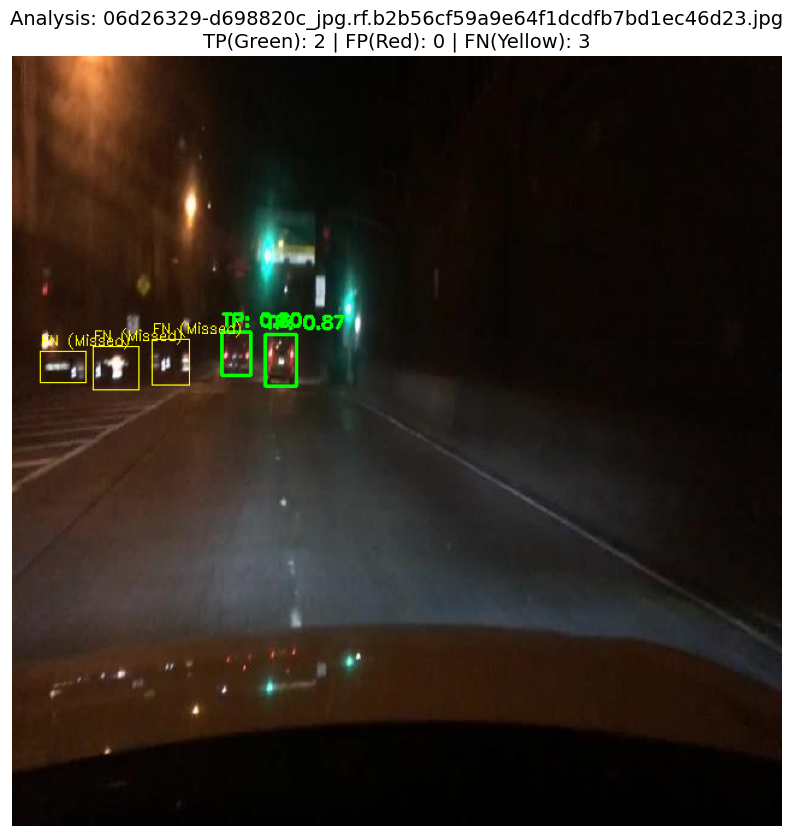

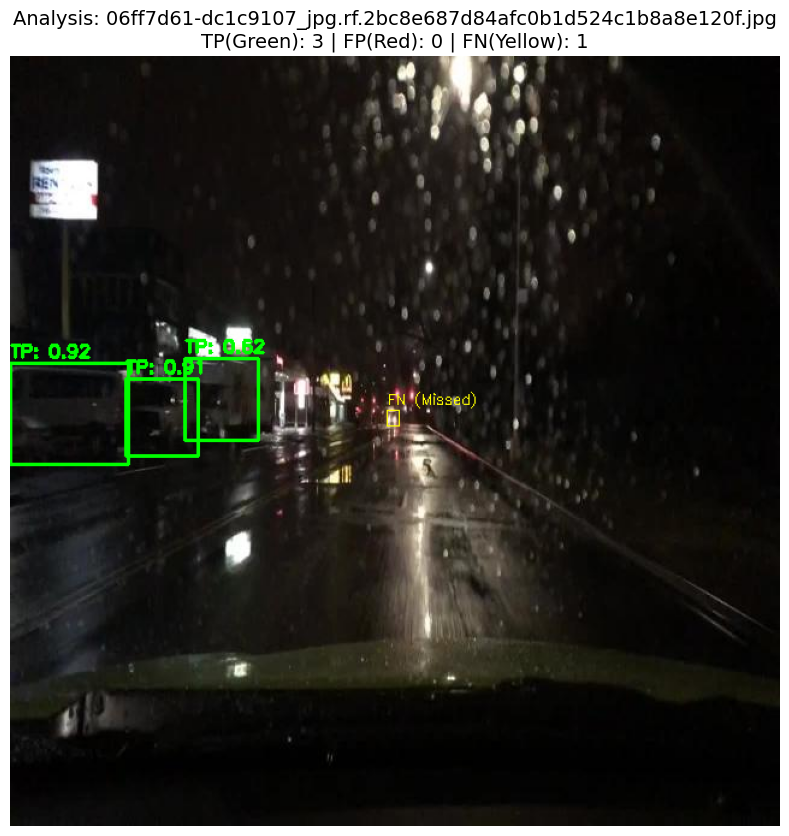

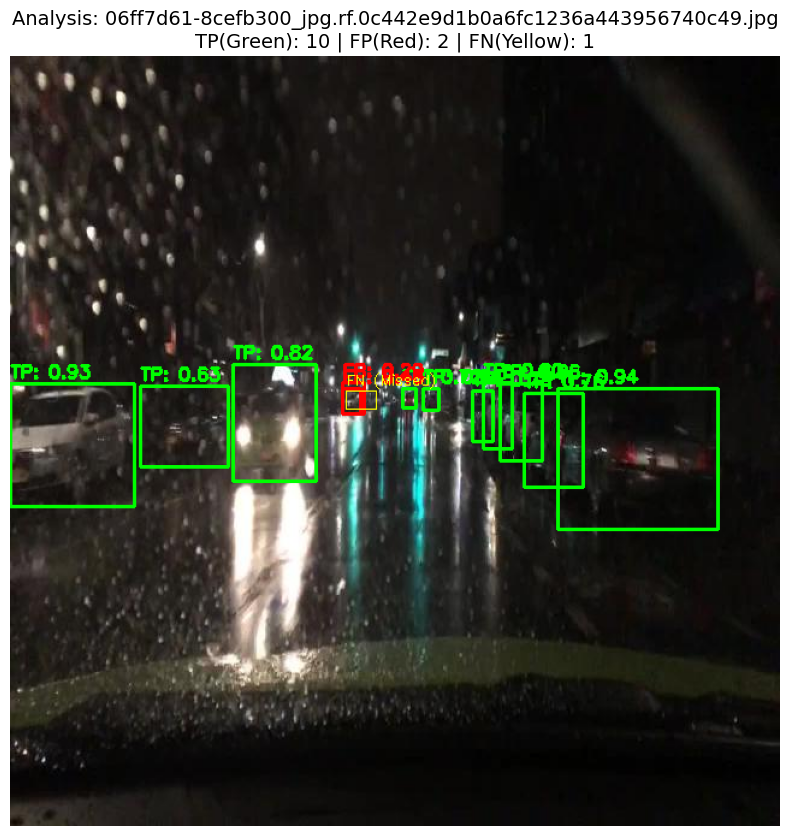

In [ ]:
import os
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO

def calculate_iou(box1, box2):
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])
    intersection = max(0, x2 - x1) * max(0, y2 - y1)
    area1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
    area2 = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union = area1 + area2 - intersection
    return intersection / union if union > 0 else 0

# 1. 설정 및 경로 (최종 모델 경로 반영)
model_path = '/content/drive/MyDrive/YOLOv11_Night/bdd100k_final_fix/weights/best.pt'
img_dir = '/content/bdd100k_night/test/images'
label_dir = '/content/bdd100k_night/test/labels'
iou_threshold = 0.45  # 정탐 판정 기준 (보통 0.45~0.5 사용)

model = YOLO(model_path)
test_images = glob.glob(os.path.join(img_dir, "*.jpg"))

# 2. 분석 실행 (3장 샘플링)
for img_path in test_images[:3]:
    img = cv2.imread(img_path)
    h, w, _ = img.shape
    img_res = img.copy()

    label_path = os.path.join(label_dir, os.path.basename(img_path).replace('.jpg', '.txt'))
    gt_boxes = []
    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            for line in f:
                _, cx, cy, nw, nh = map(float, line.split())
                gt_boxes.append([(cx-nw/2)*w, (cy-nh/2)*h, (cx+nw/2)*w, (cy+nh/2)*h])

    results = model.predict(img_path, conf=0.25, verbose=False)[0]

    matched_gt = set() # 매칭된 GT 인덱스 저장
    tp_count, fp_count = 0, 0

    # (1) 예측 박스 분석 (TP vs FP)
    for pred in results.boxes:
        p_box = pred.xyxy[0].cpu().numpy()
        p_cls = int(pred.cls[0])
        p_conf = float(pred.conf[0])

        # 각 예측 박스에 대해 가장 높은 IoU를 가진 GT 찾기
        ious = [calculate_iou(p_box, gt) for gt in gt_boxes]
        max_iou = max(ious) if ious else 0
        max_idx = np.argmax(ious) if ious else -1

        if max_iou >= iou_threshold:
            # [TP] 정탐: 초록색 (굵게)
            color = (0, 255, 0)
            label = f"TP: {max_iou:.2f}"
            matched_gt.add(max_idx)
            tp_count += 1
        else:
            # [FP] 오탐: 빨간색 (가장 굵게)
            color = (0, 0, 255)
            label = f"FP: {p_conf:.2f}"
            fp_count += 1

        cv2.rectangle(img_res, (int(p_box[0]), int(p_box[1])), (int(p_box[2]), int(p_box[3])), color, 2)
        cv2.putText(img_res, label, (int(p_box[0]), int(p_box[1]-5)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    # (2) 매칭되지 않은 GT 분석 (FN: 미검출)
    fn_count = 0
    for i, gt in enumerate(gt_boxes):
        if i not in matched_gt:
            # [FN] 미검출: 노란색 (점선 대신 얇은 실선)
            cv2.rectangle(img_res, (int(gt[0]), int(gt[1])), (int(gt[2]), int(gt[3])), (0, 255, 255), 1)
            cv2.putText(img_res, "FN (Missed)", (int(gt[0]), int(gt[1]-5)), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 255, 255), 1)
            fn_count += 1

    # (3) 결과 출력
    plt.figure(figsize=(15, 10))
    plt.imshow(cv2.cvtColor(img_res, cv2.COLOR_BGR2RGB))
    plt.title(f"Analysis: {os.path.basename(img_path)}\nTP(Green): {tp_count} | FP(Red): {fp_count} | FN(Yellow): {fn_count}", fontsize=14)
    plt.axis('off')
    plt.show()